# Algorithm Evaluation
Which to algo to select for given dataset

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# Step 1: Read the train dataset

In [2]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Step 2: Perform basic data quality checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [5]:
df.duplicated().sum()

0

### Step 3: Seperate X and Y(Survived)

In [6]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
Y = df[['Survived']]

In [7]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Step 4: Create a preprocessing pipeline for X

In [9]:
# Seperate cat and con features first
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [10]:
cat

['Sex', 'Embarked']

In [11]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [14]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [15]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [16]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


### Step 4: Apply train test split

In [17]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=42)

In [18]:
xtrain.shape

(712, 10)

In [19]:
xtest.shape

(179, 10)

### Step 5: Algo Evaluation

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [21]:
dct = {'Logistic':LogisticRegression(),
       'Decision Tree': DecisionTreeClassifier(),
       'Random Forest': RandomForestClassifier(),
       'Gradient Boost':GradientBoostingClassifier(),
       'KNN':KNeighborsClassifier(),
       'SVM':SVC()}

In [22]:
dct.items()

dict_items([('Logistic', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()), ('Gradient Boost', GradientBoostingClassifier()), ('KNN', KNeighborsClassifier()), ('SVM', SVC())])

In [23]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
train_scores = []
test_scores = []
train_cv = []
for name, model in dct.items():
    # Fit the model
    model.fit(xtrain, ytrain)
    # Predict the results for train and test
    ypred_train = model.predict(xtrain)
    ypred_test = model.predict(xtest)
    # Evaluate f1 scores for train and test
    f1_train = f1_score(ytrain, ypred_train, average='macro')
    f1_test = f1_score(ytest, ypred_test, average='macro')
    # Cross validate results for train data
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')
    f1_cv = scores.mean()
    # Append above values in list
    train_scores.append(f1_train)
    test_scores.append(f1_test)
    train_cv.append(f1_cv)
    # Print the results
    print(f'Model Name : {name}\n')
    print(f'Train F1 : {f1_train:.4f}')
    print(f'Test F1 : {f1_test:.4f}')
    print(f'Train CV 5 fold : {f1_cv:.4f}')
    print('\n================================================\n')

Model Name : Logistic

Train F1 : 0.7852
Test F1 : 0.8025
Train CV 5 fold : 0.7721


Model Name : Decision Tree

Train F1 : 0.9773
Test F1 : 0.7828
Train CV 5 fold : 0.7437




Model Name : Random Forest

Train F1 : 0.9774
Test F1 : 0.7988
Train CV 5 fold : 0.7820


Model Name : Gradient Boost

Train F1 : 0.8917
Test F1 : 0.8113
Train CV 5 fold : 0.7926


Model Name : KNN

Train F1 : 0.8489
Test F1 : 0.7899
Train CV 5 fold : 0.7788


Model Name : SVM

Train F1 : 0.8239
Test F1 : 0.8069
Train CV 5 fold : 0.8047




### Create a dataframe to show above results

In [24]:
dct.keys()

dict_keys(['Logistic', 'Decision Tree', 'Random Forest', 'Gradient Boost', 'KNN', 'SVM'])

In [25]:
res = {'name':list(dct.keys()),
       'Train':train_scores,
       'Test':test_scores,
       'CV':train_cv}

In [26]:
df_res = pd.DataFrame(res)
df_res

,name,Train,Test,CV
0,Logistic,0.785186,0.802505,0.772135
1,Decision Tree,0.977336,0.782767,0.743709
2,Random Forest,0.977407,0.798818,0.781995
3,Gradient Boost,0.891720,0.811331,0.792572
4,KNN,0.848914,0.789906,0.778796
5,SVM,0.823883,0.806942,0.804746


In [27]:
df_res.sort_values(by='CV', ascending=False)

,name,Train,Test,CV
5,SVM,0.823883,0.806942,0.804746
3,Gradient Boost,0.891720,0.811331,0.792572
2,Random Forest,0.977407,0.798818,0.781995
4,KNN,0.848914,0.789906,0.778796
0,Logistic,0.785186,0.802505,0.772135
1,Decision Tree,0.977336,0.782767,0.743709


### Build the Best model SVM as it has higest CV score of 0.8047

In [28]:
best_model = SVC(probability=True)
best_model.fit(xtrain, ytrain)

SVC(probability=True)

### Evaluate best model in detail

In [29]:
best_model.score(xtrain, ytrain)

0.8384831460674157

In [30]:
best_model.score(xtest, ytest)

0.8156424581005587

In [31]:
ypred_train = best_model.predict(xtrain)
ypred_test = best_model.predict(xtest)

In [32]:
ypred_train[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [33]:
ypred_test[0:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [34]:
ytest.head()

,Survived
709,1
439,0
840,0
720,1
39,1


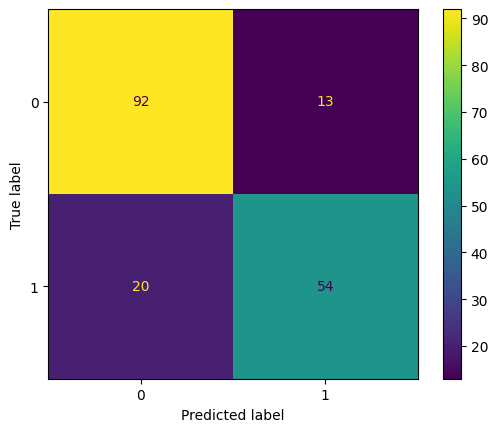

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, xtest, ytest)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



### Step 8: Out of sample prediction with svm

In [37]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [38]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [39]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,0.394887,-0.474545,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,1.355510,0.432793,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,2.508257,-0.474545,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.181487,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,-0.565736,0.432793,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0


### Predict the results along with probability

In [40]:
preds = best_model.predict(xnew_pre)
probs = best_model.predict_proba(xnew_pre)

In [41]:
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [44]:
best_model.classes_

array([0, 1], dtype=int64)

In [43]:
probs[0:5]

array([[0.84516568, 0.15483432],
       [0.41524769, 0.58475231],
       [0.85326346, 0.14673654],
       [0.85185733, 0.14814267],
       [0.44326273, 0.55673727]])

In [46]:
prob_sur = probs[:, 1]
prob_sur[0:5]

array([0.15483432, 0.58475231, 0.14673654, 0.14814267, 0.55673727])

In [47]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [48]:
df_final['Survived_pred'] = preds
df_final['Prob_surv'] = prob_sur

In [49]:
df_final

,PassengerId,Survived_pred,Prob_surv
0,892,0,0.154834
1,893,1,0.584752
2,894,0,0.146737
3,895,0,0.148143
4,896,1,0.556737
...,...,...,...
413,1305,0,0.148844
414,1306,1,0.879811
415,1307,0,0.155707
416,1308,0,0.148844


In [50]:
df_final['Survived_pred'].value_counts()

Survived_pred
0    264
1    154
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

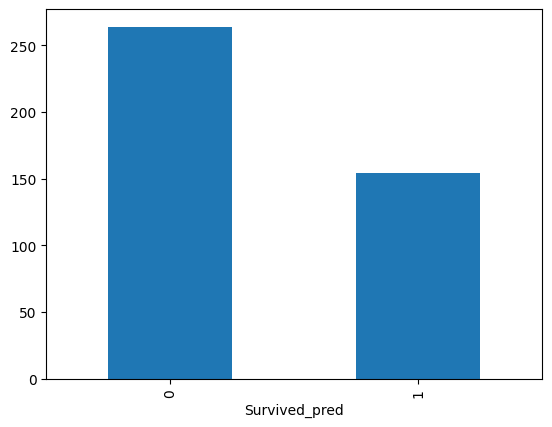

In [51]:
df_final['Survived_pred'].value_counts().plot(kind='bar')

### Save results to csv

In [52]:
df_final.to_csv("Results.csv", index=False)